# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [4]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

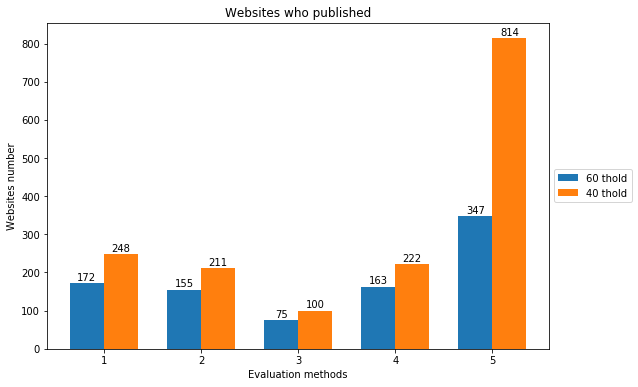

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

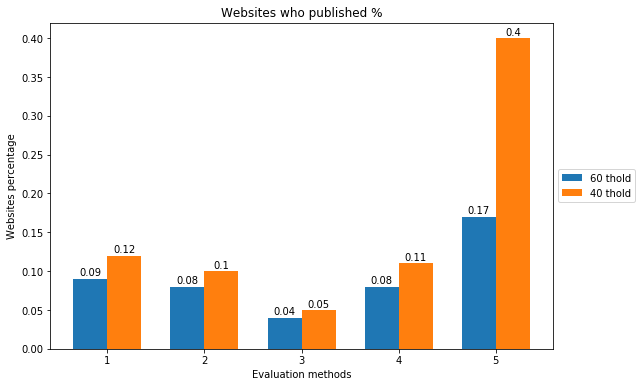

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

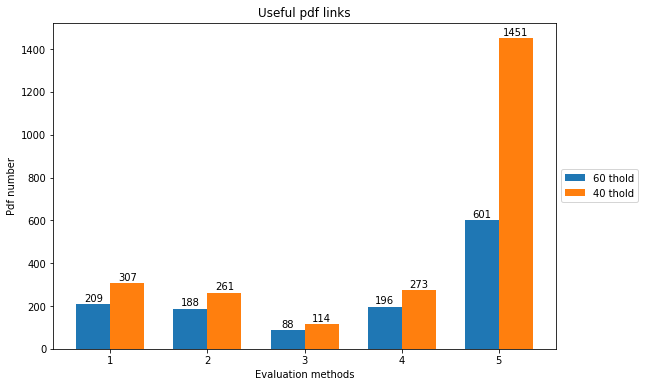

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

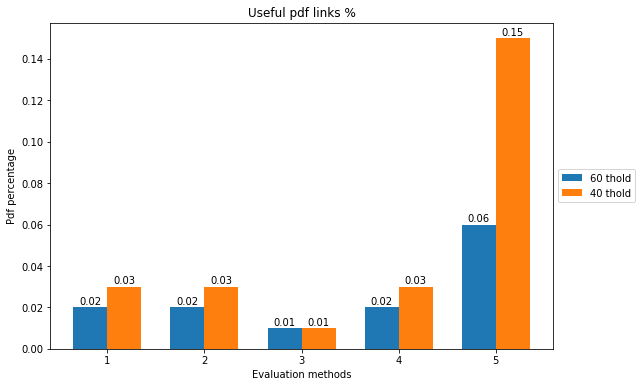

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

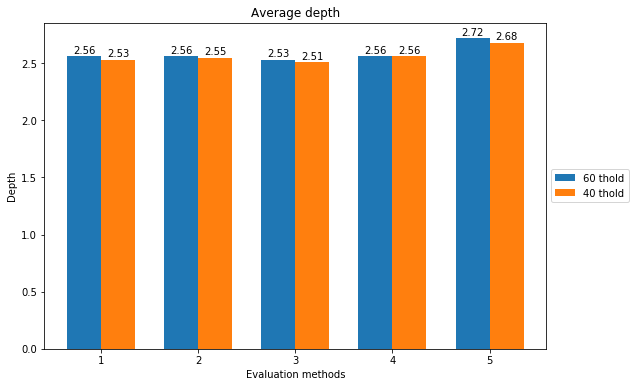

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

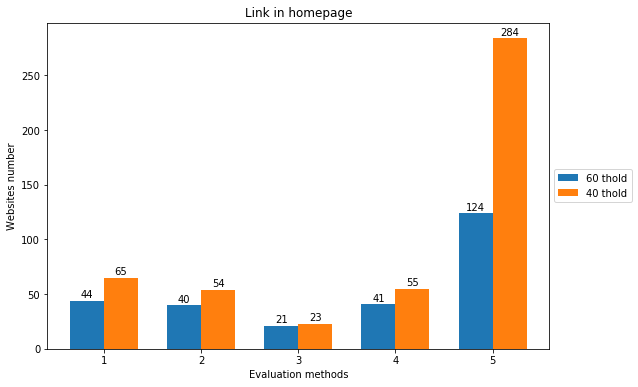

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


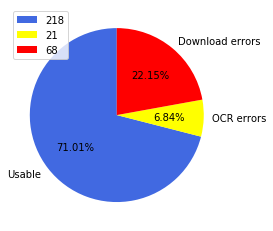

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'

val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

In [13]:
# plots

# Analisi entità

# Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, sia solo quelle principali.

Sono qui rappresentati due modelli, il primo considera tutte le entità, successivamente solo quelle principali, presenti nei documenti, il secondo si basa su un preprocessing più restrittivo: sono mantenute solo le entità che compaiono in almeno N documenti distinti. 

# Modelli su tutte le entità

A seguire i modelli senza e con vincoli di frequenza sulla lista completa di entità per ogni documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta viconli sulle keyword.
### Preprocessing

Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. dtm_tf : frequency vector
2. tf_vectorizer: count vectorizer contentente il vocabolario estratto dai documenti

In [14]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [15]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per il primo caso, non avendo restrizioni sulla frequenza nei documenti e avendo tutte le entità per ogni testo, si assume che:
1. i topics presenti siano tanti
2. i testi siano composti da non troppi topics rispetto al totale 
3. ogni topic usi un sottoinsieme non troppo grande della totalità delle keyword nel vocabolario 

In [43]:
%%capture
from sklearn.decomposition import LatentDirichletAllocation

topics = 7
alpha = 0.3
beta = 0.2

lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= alpha, topic_word_prior = beta, random_state=0)
lda.fit(dtm_tf)

### Visualizzazione

I topics trovati sono visualizzati con pyLDAvis.

In [44]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.005600 -0.023824       1        1  52.984813
0     -0.058044 -0.051550       2        1  14.933406
2     -0.091538 -0.002215       3        1  12.365483
1      0.042512  0.020428       4        1   9.796116
3      0.053206 -0.095864       5        1   6.461341
6      0.162041  0.062734       6        1   1.905027
4     -0.102576  0.090291       7        1   1.553814, topic_info=                       Term        Freq       Total Category  logprob  loglift
13                  economy  132.000000  132.000000  Default  30.0000  30.0000
14                   energy  121.000000  121.000000  Default  29.0000  29.0000
34           sustainability  115.000000  115.000000  Default  28.0000  28.0000
35  sustainable_development   96.000000   96.000000  Default  27.0000  27.0000
15                     euro  101.000000  101.000000  Default  26.0000  26.0000
..                      ...         ...         ...      ...      ...      ...
24               management    0.354147  175.915814   Topic7  -5.3304  -2.0436
15                     euro    0.352158  101.725367   Topic7  -5.3360  -1.5015
17           european_union    0.352144  117.354613   Topic7  -5.3361  -1.6445
5                 community    0.352126  105.294329   Topic7  -5.3361  -1.5361
2                  business    0.351995  122.765715   Topic7  -5.3365  -1.6900

[267 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.594899  behavior
0         2  0.168368  behavior
0         3  0.190817  behavior
0         5  0.011225  behavior
0         7  0.022449  behavior
...     ...       ...       ...
43        2  0.088001     water
43        3  0.205335     water
43        4  0.176002     water
43        6  0.058667     water
43        7  0.019556     water

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 2, 4, 7, 5])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue è stato imposto un vincolo sulla presenza delle keyword in N documenti distinti, in modo da scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio.

A seguire la grandezza del vocabolario in relazione al al valore di N, espresso in percentuale sul totale.
Si nota che anche nel caso in cui N sia molto piccolo in percentuale, la grandezza del vocabolario si riduce di molto rispetto allo scenario mostrato in precedenza.

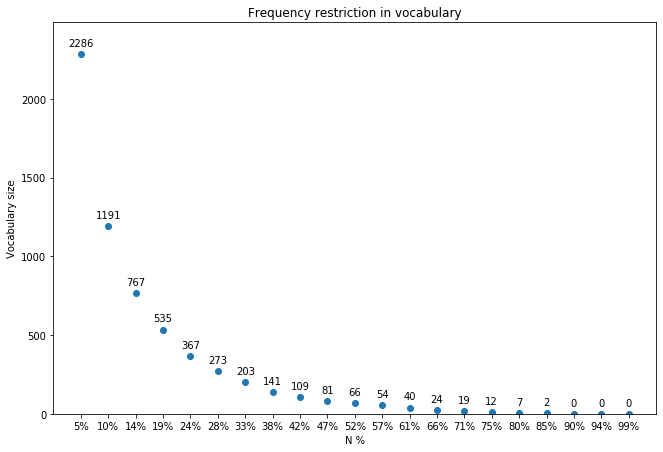

In [18]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare:
1. si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento
2. i documenti saranno __composti da più topics__ rispetto al caso precedente
3. non cambia la grandezza di ogni topic

A seguire il modello che considera solo i termini presenti in almeno il __50%__ dei __documenti__.

Cambiando i paramentri del modello e includendo il constraint sulla frequenza si possono notare topic più distinti.

In [19]:
from lda_topic_model import preprocess_freq_count


perc = 0.5
N = round(170 * perc)

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N)

topics = 5
alpha = 0.8
beta = 0.4

lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= alpha, topic_word_prior = beta, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.027167  0.080787       1        1  28.982514
1     -0.146071  0.082722       2        1  27.014221
3     -0.133683 -0.153816       3        1  22.392766
2      0.215188 -0.043704       4        1  12.522360
0      0.091733  0.034012       5        1   9.088139, topic_info=                  Term         Freq        Total Category  logprob  loglift
23                euro  2726.000000  2726.000000  Default  30.0000  30.0000
2   board_of_directors  2380.000000  2380.000000  Default  29.0000  29.0000
56      sustainability  9670.000000  9670.000000  Default  28.0000  28.0000
36          investment  1679.000000  1679.000000  Default  27.0000  27.0000
27             finance  1573.000000  1573.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
50                risk    96.721893  1778.054689   Topic5  -4.4843  -0.5132
58          technology   134.332084  2571.302691   Topic5  -4.1558  -0.5537
4     business_process    60.156643  1137.734728   Topic5  -4.9592  -0.5416
56      sustainability   220.266207  9670.386028   Topic5  -3.6613  -1.3838
45              policy    68.550217  1682.911037   Topic5  -4.8286  -0.8025

[204 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.290530  air_pollution
0         2  0.667831  air_pollution
0         3  0.032539  air_pollution
0         5  0.008522  air_pollution
1         1  0.533480       behavior
...     ...       ...            ...
69        1  0.176289          world
69        2  0.164537          world
69        3  0.650312          world
69        4  0.003918          world
69        5  0.003918          world

[346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di entità principali.

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei modelli più specifici.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà.

In [20]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, __aumentando__ i valori di __alpha__ e __beta__ rispetto al modello su tutte le entità.

In [24]:
topics = 5
alpha = 0.45
beta = 0.55

lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= alpha, topic_word_prior = beta, random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056881  0.039443       1        1  38.394634
3     -0.058520 -0.049125       2        1  25.307520
1      0.031474 -0.067593       3        1  18.365736
0      0.038520  0.021438       4        1  13.262706
4     -0.068355  0.055837       5        1   4.669404, topic_info=                  Term        Freq       Total Category  logprob  loglift
6              company  142.000000  142.000000  Default  30.0000  30.0000
13             economy  130.000000  130.000000  Default  29.0000  29.0000
24          management  177.000000  177.000000  Default  28.0000  28.0000
18             finance  103.000000  103.000000  Default  27.0000  27.0000
26              policy  124.000000  124.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
15                euro    1.441924  100.671582   Topic5  -5.0267  -1.1817
0             behavior    1.152024   89.133365   Topic5  -5.2511  -1.2845
4        communication    1.191360   93.877726   Topic5  -5.2176  -1.3028
37                time    0.954320   94.906310   Topic5  -5.4394  -1.5355
1   board_of_directors    0.885983   88.138832   Topic5  -5.5137  -1.5358

[183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.594615  behavior
0         2  0.201945  behavior
0         3  0.044877  behavior
0         4  0.157068  behavior
0         5  0.011219  behavior
...     ...       ...       ...
43        1  0.400204     water
43        2  0.040020     water
43        3  0.460234     water
43        4  0.090046     water
43        5  0.010005     water

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

## Modello con vincoli di frequenza - entità principali

Si può notare che l'andamento della grandezza del vocabolario in funzione alla grandezza della restrizione applicata è pressochè uguale al precedente, l'altezza della curva è minore visto la dimensione più ristretta del vocabolario iniziale. 

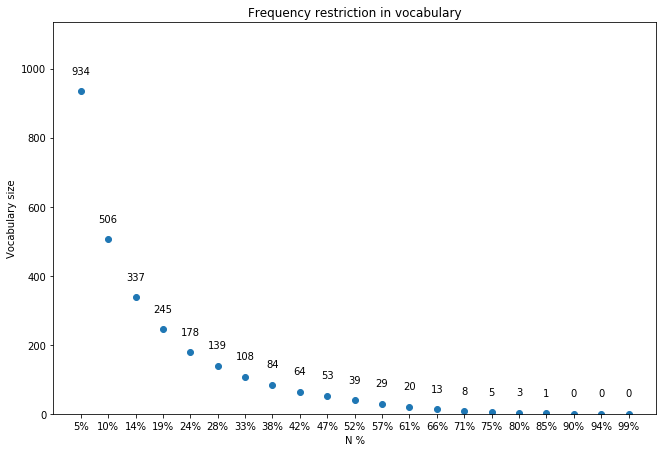

In [22]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path)
plt.show()

Nel modello sono stati __ridotti__ i __topics__ ricercati, avendo introdotto una restrizione, ed è __aumentato__ il valore di __alpha__, tenendo conto della presenza di più topics nei singoli documenti 

In [23]:
perc = 0.5
N = round(170 * perc)
        
dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_top_entities_en.csv", N)
        
topics = 4
alpha = 0.8
beta = 0.1

lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= alpha, topic_word_prior = beta, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.061183  0.038619       1        1  26.840617
2      0.065189 -0.025667       2        1  26.437758
3     -0.080911  0.036062       3        1  23.688503
1     -0.045461 -0.049013       4        1  23.033122, topic_info=                  Term        Freq       Total Category  logprob  loglift
12           economics   88.000000   88.000000  Default  30.0000  30.0000
40              value_   88.000000   88.000000  Default  29.0000  29.0000
15                euro  101.000000  101.000000  Default  28.0000  28.0000
21          innovation   96.000000   96.000000  Default  27.0000  27.0000
32     standardization   88.000000   88.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
38            training   21.309559  130.751909   Topic4  -3.9294  -0.3459
5            community   17.230036  105.844882   Topic4  -4.1419  -0.3471
30              safety   18.179247  115.854274   Topic4  -4.0883  -0.3838
1   board_of_directors   12.977034   87.976360   Topic4  -4.4254  -0.4457
6              company   19.036595  140.619761   Topic4  -4.0422  -0.5315

[153 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.585506            behavior
0         2  0.247714            behavior
0         3  0.135117            behavior
0         4  0.033779            behavior
1         1  0.193234  board_of_directors
...     ...       ...                 ...
42        4  0.257560    waste_management
43        1  0.226786               water
43        2  0.315528               water
43        3  0.059161               water
43        4  0.404270               water

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])